# Exploratory Data Analysis & Modeling

The IMO database tends to contain larger, more legitimate vessels. Those not listed on the vessel registry and having a high number of gap events are more suspicious. This section investigates patterns and relationships among the vessels that _did not_ appear in the IMO database.

In this exploratory analysis I use clustering algorithms to identify groups of vessels exhibiting similar behavior. I focus on patterns within the three largest clusters identified by the strongest performing model to see if any broader insights can be gleaned.

## Contents
- [EDA Full Dataset](#EDA-Full-Dataset)
- [DBSCAN Model 1: Location](#DBSCAN-Model-1)
- [DBSCAN Model 2: Location and Gap Length](#DBSCAN-Model-2)
- [HDBSCAN Model: Location and Gap Length](#HDBSCAN-Model)
- [EDA Clusters](#EDA-Clusters)
- [Conclusions](#Conclusions)
- [References](#References)

## Data Dictionary

| Column | Datatype | Description |
|---------------------------|----------|-------------------------------------------------------------------------------------------------------|
| mmsi | int64 | Maritime Mobile Service Identity (mmsi) numbers are a vessel's unique 9-digit AIS ID |
| gap_hours | float64 | length of time (hours) that the vessel was offline |
| gap_distance_m | float64 | distance (meters) between the vessel's off timestamp and on timestamp |
| gap_implied_speed_knots | float64 | vessel speed in nautical miles per hour |
| positions_per_day | float64 | the number of positions a vessel assumes, captured by satellite per day |
| vessel_class | object | vessel geartype |
| flag | object | The state a vessel is registered or licensed under |
| off_timestamp | object | timestamp AIS was turned off |
| off_msgid | object | message ID from AIS turning off |
| off_lat | float64 | latitude when AIS turned off |
| off_lon | float64 | longitude when AIS turned off |
| off_type | object | the class of AIS device (A or B), Class A devices are more expensive, have stronger signals and broadcast more frequently |
| off_receiver_type | object | whether the AIS message was recieved by a satellite or terrestrial receiver when turned off |
| off_distance_from_shore_m | float64 | distance from shore when AIS turned off |
| on_timestamp | object | timestamp AIS was turned on |
| on_msgid | object | message ID from AIS turning on |
| on_lat | float64 | latitude when AIS turned on |
| on_lon | float64 | longitude when AIS turned on |
| on_type | object | the class of AIS device (A or B), class A devices have stronger signals and broadcast more frequently |
| on_receiver_type | object | whether the AIS message was recieved by a satellite or terrestrial receiver when turned on |
| on_distance_from_shore_m | float64 | distance from shore when AIS turned on |
| off_cluster | int64 | assigned cluster from DBSCAN algorithm |

## Import Packages and Data

In [107]:
# standard data manipulation libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Clustering models and visualizers
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN
import hdbscan
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
from yellowbrick.cluster import SilhouetteVisualizer

In [61]:
# import IMO non registered list and gap events dataset
imo_notreg = pd.read_csv('../data/imo_notreg.csv')
gap_events = pd.read_csv('../data/raw_sample.csv') 

In [62]:
# check the contents
print(f'Total Non-Registered Vessel List: {len(imo_notreg)}')
print(f"Total Unique Vessels: {imo_notreg['0'].nunique()}")
print(f'Total Gap Event Observations: {len(gap_events)}')

Total Non-Registered Vessel List: 79066
Total Unique Vessels: 43168
Total Gap Event Observations: 500000


In [63]:
# Confirm single MMSIs are not overly represented from IMO scrape (avoid skewed analysis)
imo_notreg['0'].value_counts().head()

563022450    14
431008005    13
416005616    12
228208700    12
224220130    11
Name: 0, dtype: int64

## EDA Full Dataset

### Combine

In [64]:
# Filter the full dataset to only include the non registered vessels
gap_notreg = gap_events[gap_events['ssvid'].isin(imo_notreg['0'])]
gap_notreg.shape

(346762, 21)

In [65]:
gap_notreg.nunique()

ssvid                         43168
gap_hours                     35607
gap_distance_m               346365
gap_implied_speed_knots      346378
positions_per_day             28581
vessel_class                     17
flag                            131
off_timestamp                345233
off_msgid                    346750
off_lat                      331448
off_lon                      332241
off_type                          2
off_receiver_type                 2
off_distance_from_shore_m      1178
on_timestamp                 345358
on_msgid                     346750
on_lat                       329730
on_lon                       330766
on_type                           2
on_receiver_type                  2
on_distance_from_shore_m       1194
dtype: int64

In [66]:
# change ssvid column name for consistency
gap_notreg = gap_notreg.rename(columns={'ssvid':'mmsi'})

In [67]:
gap_notreg[['gap_hours', 'gap_distance_m', 'gap_implied_speed_knots', 'positions_per_day',
           'off_distance_from_shore_m', 'on_distance_from_shore_m']].describe()

,gap_hours,gap_distance_m,gap_implied_speed_knots,positions_per_day,off_distance_from_shore_m,on_distance_from_shore_m
count,346762.000000,3.467620e+05,346762.000000,344906.000000,3.467540e+05,3.467560e+05
mean,125.473019,2.873190e+04,0.414658,11.761397,1.838358e+04,1.865638e+04
std,429.313197,1.693180e+05,3.504960,41.770756,7.212948e+04,7.240180e+04
min,12.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00
25%,16.733333,3.407681e+02,0.003546,0.001704,0.000000e+00,0.000000e+00
50%,30.550000,3.613040e+03,0.044143,0.051323,2.000000e+03,2.000000e+03
75%,83.016667,1.703127e+04,0.237987,1.785874,1.300000e+04,1.300000e+04
max,15511.116667,1.919246e+07,617.980208,735.613968,1.994000e+06,2.002000e+06


### Clean

#### Duplicates

In [68]:
# Check for duplicate rows
duplicates = gap_notreg.duplicated()
gap_notreg[duplicates].head()

,mmsi,gap_hours,gap_distance_m,gap_implied_speed_knots,positions_per_day,vessel_class,flag,off_timestamp,off_msgid,off_lat,...,off_type,off_receiver_type,off_distance_from_shore_m,on_timestamp,on_msgid,on_lat,on_lon,on_type,on_receiver_type,on_distance_from_shore_m
181846,367799370,68.150000,388349.446373,3.076917,NaN,fishing,USA,2019-08-21T00:48:26Z,878e6556-7c2c-13ea-421a-0000394ec61b,53.878333,...,NaN,satellite,0.0,2019-08-23T20:58:23Z,3c26a05d-d46b-194b-e03c-83688a7ec798,57.137093,-168.758933,A,satellite,75000.0
215367,251830940,62.916667,5841.122395,0.050129,110.257670,pots_and_traps,ISL,2019-08-23T13:01:06Z,b8b3da39-8310-8870-db21-633caf24635e,66.046280,...,B,satellite,1000.0,2019-08-26T03:56:11Z,c2010308-2c4c-562d-a233-024afc9f5c9a,66.066978,-17.464547,B,terrestrial,5000.0
244896,316023416,16.416667,2826.827867,0.092977,4.078816,drifting_longlines,CAN,2019-08-07T14:17:16Z,f8529f7b-f4ae-bb0c-468f-0c7eca9e986f,42.117038,...,B,satellite,144000.0,2019-08-08T06:42:20Z,7b3bb14d-bf50-6c77-795f-b7c780726404,42.097015,-66.313693,B,satellite,146000.0
250121,412440617,12.266667,94.193130,0.004146,49.255718,tuna_purse_seines,CHN,2019-06-22T12:43:42Z,3414014d-aa73-7851-b376-6730c685a696,6.076032,...,B,satellite,14000.0,2019-06-23T01:00:41Z,2cf6057b-4e26-7120-2ddb-71730387eb27,6.075303,-55.293493,B,satellite,14000.0
318469,201601321,13.316667,18897.623709,0.766250,8.355057,drifting_longlines,ALB,2019-09-13T09:16:16Z,4558b176-bfa9-3d41-28a7-ea194e17ef0f,10.044378,...,B,satellite,417000.0,2019-09-13T22:36:02Z,eab1b595-4355-8a2f-8818-9fc3327e857b,9.899655,131.547628,B,satellite,401000.0


In [69]:
# Drop duplicate rows
gap_notreg = gap_notreg.drop_duplicates()
gap_notreg.shape

(346750, 21)

#### Remove Vessels at Port

In [70]:
# Vessels at shore for the entire gap event don't provide much insight
at_shore = gap_notreg.loc[(gap_notreg['on_distance_from_shore_m'] == 0.00) & (gap_notreg['off_distance_from_shore_m'] == 0.00)]

print(f"{len(at_shore)} vessels (22% of observations) have on and off timestamps at shore.")

75214 vessels (22% of observations) have on and off timestamps at shore.


In [71]:
# Confirm at shore by checking distance
print(f"{len(at_shore.loc[(at_shore['gap_distance_m'] < 100)])} \
of these vessels traveled under 100m during the gap event.")

print(f"{len(at_shore.loc[(at_shore['gap_distance_m'] == 0)])} \
of these vessels traveled 0m during the gap event.")

41818 of these vessels traveled under 100m during the gap event.
232 of these vessels traveled 0m during the gap event.


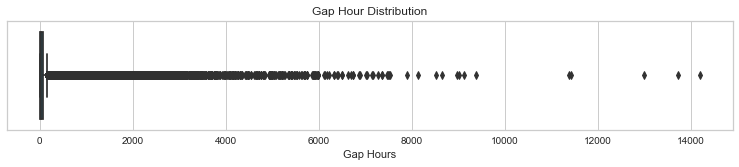

In [72]:
# What is the gap hour distribution for "at shore" vessels    
fig, ax = plt.subplots(figsize=(13,2))

sns.boxplot(x=at_shore['gap_hours'], ax=ax)
ax.set_title(f"Gap Hour Distribution")
ax.set_xlabel('Gap Hours')
ax.tick_params(labelsize=10);

In [73]:
# drop observations where vessel is at shore and has gap length over 2,000 hrs
gap_notreg.drop(at_shore.loc[at_shore['gap_hours'] > 2000].index, axis=0, inplace=True)

In [74]:
# How many observations of 0 positions per day?
len(gap_notreg[(gap_notreg['positions_per_day'] == 0)])

1460

#### Null Values

In [75]:
# Check for null values
gap_notreg.isnull().sum()

mmsi                            0
gap_hours                       0
gap_distance_m                  0
gap_implied_speed_knots         0
positions_per_day            1855
vessel_class                    0
flag                            0
off_timestamp                   0
off_msgid                       0
off_lat                         0
off_lon                         0
off_type                     1855
off_receiver_type               0
off_distance_from_shore_m       8
on_timestamp                    0
on_msgid                        0
on_lat                          0
on_lon                          0
on_type                      1567
on_receiver_type                0
on_distance_from_shore_m        6
dtype: int64

In [76]:
# Impute 0 for the distance from shore null values
gap_notreg['on_distance_from_shore_m'].fillna(0, inplace=True)
gap_notreg['off_distance_from_shore_m'].fillna(0, inplace=True)

In [77]:
# Are nulls for positions_per_day and off_type related?
# Maybe if device type not known when AIS turned off, cannot record positions
gap_notreg[(gap_notreg['positions_per_day'].isnull() == True) & (gap_notreg['off_type'].isnull() == True)]

,mmsi,gap_hours,gap_distance_m,gap_implied_speed_knots,positions_per_day,vessel_class,flag,off_timestamp,off_msgid,off_lat,...,off_type,off_receiver_type,off_distance_from_shore_m,on_timestamp,on_msgid,on_lat,on_lon,on_type,on_receiver_type,on_distance_from_shore_m
376,441177000,14.250000,11806.436439,0.447366,NaN,set_longlines,KOR,2019-01-17T23:58:00Z,e8999767-efbc-5c92-b974-d7343d7aabd6,33.275000,...,NaN,satellite,23000.0,2019-01-18T14:13:22Z,090ddc9c-603f-523f-b645-35bad933c342,33.230000,126.993333,NaN,satellite,18000.0
407,548040400,41.066667,5450.100129,0.071660,NaN,other_purse_seines,PHL,2019-04-27T19:36:35Z,bd7598d8-9897-5f0d-8dfc-9afba7f43f66,6.846667,...,NaN,satellite,3000.0,2019-04-29T12:41:00Z,820ebede-9dba-8166-dc48-f6230dec6a8e,6.892142,122.081752,A,satellite,1000.0
430,412331061,14.000000,350067.633318,13.501529,NaN,squid_jigger,CHN,2018-12-21T11:20:51Z,70785358-b0b7-58e9-89c9-9cf23425926f,22.700000,...,NaN,satellite,84000.0,2018-12-22T01:20:52Z,89612178-2025-540f-bba1-d7cf0577790b,20.035000,115.651667,NaN,satellite,133000.0
930,247200190,55.900000,106.126405,0.001025,NaN,trawlers,ITA,2019-02-15T19:47:55Z,a01311d7-afb3-b527-cd92-62daefbffbd8,44.308333,...,NaN,satellite,0.0,2019-02-18T03:42:22Z,f7a54ea0-9ca4-582f-8720-b4670d378c2a,44.309145,9.334035,A,terrestrial,0.0
1553,440117480,12.550000,18963.697805,0.815903,NaN,fishing,KOR,2019-11-28T20:59:23Z,38105fbd-0018-bbc4-b9c4-f254c670444f,35.136667,...,NaN,satellite,76000.0,2019-11-29T09:32:36Z,4e1c3800-5ba1-344b-35ef-4fa16bd9737f,35.306667,130.145000,NaN,satellite,68000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
498621,440123480,17.433333,0.000000,0.000000,NaN,fishing,KOR,2018-12-24T04:45:05Z,81f4d8f7-3b48-5b18-8ae4-0a53135dc4a2,34.730000,...,NaN,satellite,1000.0,2018-12-24T22:12:01Z,b418cbee-1dd5-5f41-9e63-58073be19d39,34.730000,127.730000,NaN,satellite,1000.0
498655,227825000,79.466667,32013.546185,0.217524,NaN,trawlers,FRA,2018-10-18T01:00:32Z,11de69c6-e642-3b5a-b93c-90233d6a4020,50.286667,...,NaN,satellite,30000.0,2018-10-21T08:28:53Z,2bff4d29-5922-5922-b906-18cc9b147963,50.060452,1.379730,A,terrestrial,0.0
499178,211572000,21.500000,0.000000,0.000000,NaN,trawlers,DEU,2019-11-27T23:35:01Z,50431686-5e7a-5a35-7492-951e7661a185,54.126667,...,NaN,satellite,0.0,2019-11-28T21:05:04Z,4af6204e-4883-501b-adcc-74476492a931,54.126667,8.861667,NaN,satellite,0.0
499335,440141650,20.983333,21588.541252,0.555530,NaN,other_purse_seines,KOR,2019-12-14T00:04:03Z,5d566d1a-d627-fb86-599d-c80c0315b796,34.903333,...,NaN,satellite,1000.0,2019-12-14T21:04:01Z,c6d93488-148c-567f-b847-86f0561291e7,34.710000,128.065000,NaN,satellite,2000.0


#### Timestamps

In [78]:
# Change time columns to datetime
gap_notreg['off_timestamp'] = pd.to_datetime(gap_notreg['off_timestamp'], format='%Y-%m-%d %H:%M:%S')
gap_notreg['on_timestamp'] = pd.to_datetime(gap_notreg['on_timestamp'], format='%Y-%m-%d %H:%M:%S')

In [79]:
# Check timeframe of datatset
print(f"Start date: {gap_notreg['off_timestamp'].min()}")
print(f"End date: {gap_notreg['off_timestamp'].max()}")

Start date: 2018-01-01 00:05:37+00:00
End date: 2019-12-31 09:48:32+00:00


### Explore

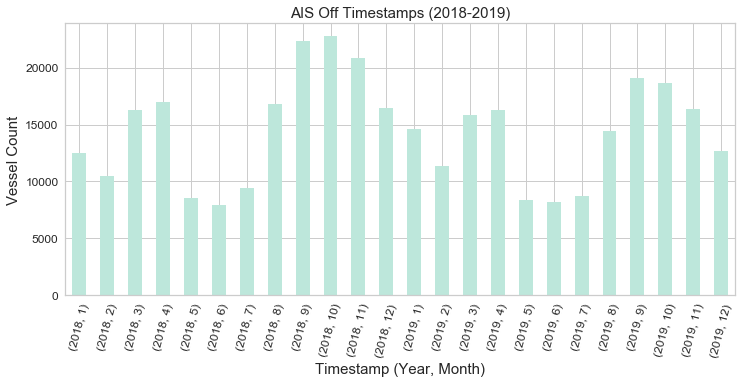

In [80]:
# Visualize the distribution of AIS off timestamps across 2-year period

plt.figure(figsize=(12,5))

# Group dataframe by month and year
timing = gap_notreg['off_timestamp'].groupby([gap_notreg['off_timestamp'].dt.year,
                                              gap_notreg['off_timestamp'].dt.month])

ax = timing.count().plot(kind="bar", rot=75, cmap='icefire')
ax.set_xlabel("Timestamp (Year, Month)", fontsize=15)
ax.set_ylabel("Vessel Count", fontsize=15)
ax.set_title("AIS Off Timestamps (2018-2019)", fontsize=15)
ax.tick_params(labelsize=12);

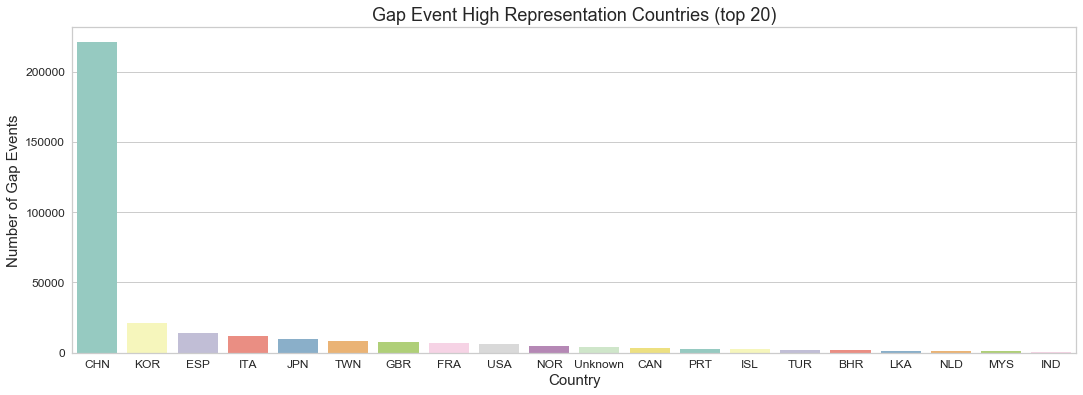

In [81]:
# Check which countries have the most gap events

plt.figure(figsize=(18,6))
gap_by_country = sns.countplot(x="flag", data=gap_notreg, palette="Set3",
                  order=gap_notreg['flag'].value_counts().iloc[:20].index)

gap_by_country.set_xlabel('Country', fontsize=15)
gap_by_country.set_ylabel('Number of Gap Events', fontsize=15)
gap_by_country.set_title('Gap Event High Representation Countries (top 20)', fontsize=18)
gap_by_country.tick_params(labelsize=12);   


In [82]:
# The vessels with the most observations are from which countries?
gap_notreg.groupby('flag')['mmsi'].value_counts().sort_values(ascending=False).head(10)

flag  mmsi     
GBR   235067061    54
CHN   412465495    49
KOR   440152920    48
FRA   227594760    47
TWN   416005071    47
USA   366977270    46
ESP   224080660    45
KOR   440004120    45
AUS   503051090    44
BGR   207822650    44
Name: mmsi, dtype: int64

In [83]:
# 22% of observations are vessels with AIS on and off timestamps at shore

at_shore = gap_notreg.loc[(gap_notreg['on_distance_from_shore_m'] == 0.00) & (gap_notreg['off_distance_from_shore_m'] == 0.00)]

len(at_shore)

74337

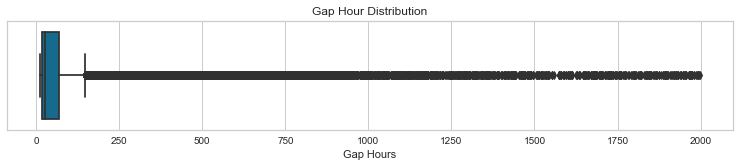

In [84]:
# What is the gap hour distribution for "at shore" vessels    
fig, ax = plt.subplots(figsize=(13,2))

sns.boxplot(x=at_shore['gap_hours'], ax=ax)
ax.set_title(f"Gap Hour Distribution")
ax.set_xlabel('Gap Hours')
ax.tick_params(labelsize=10);

In [85]:
# drop observations where vessel is at shore and has gap length over 2,000 hrs
gap_notreg.drop(at_shore.loc[at_shore['gap_hours'] > 2000].index, axis=0, inplace=True)

# DBSCAN Model 1: Clustering Coordinates Where Vessels Go Dark

The popular clustering algorithm DBSCAN is a useful tool for exploration at this stage because it creates clusters based on density connected regions. KMeans clustering is not as applicable because it doesn't consider density and will try to create the same sized cluster regardless of how the data is scattered. I use the location at the moment vessels go dark (turn off AIS transponders) as the features.

DBSCAN's behavior is defined by three parameters: `eps` or epsilon, `min_samples` and `metric`. `eps` defines the distance threshold between points in order to be considered neighbors and `min_samples` defines the number of points in order to be considered a cluster. `metric` refers to the distance metric. In this case, the latitude and longitude coordinates must be [converted from degrees to radians](https://geoffboeing.com/2014/08/clustering-to-reduce-spatial-data-set-size/) in order to use Scikit-Learn's haversine distance metric. Scaling is not required since I only use latitude longitude coordinates as features.

## Prepare Features

In [86]:
# Make a dataframe of only lat/lon at AIS switch off
X = gap_notreg[['off_lat', 'off_lon']]

# convert to numpy matrix
X = X.to_numpy()

In [87]:
# convert epsilon and coordinates to radians 
# code adapted from Geoff Boeing (see refs)
kms_per_radian = 6371.0088
epsilon = 90 / kms_per_radian 

X = np.radians(X)

## Fit and Evaluate

In [88]:
# instantiate and fit
dbscan = DBSCAN(eps=epsilon, min_samples= 50, metric='haversine')
dbscan.fit(X)

DBSCAN(algorithm='auto', eps=0.014126491239503547, leaf_size=30,
       metric='haversine', metric_params=None, min_samples=50, n_jobs=None,
       p=None)

In [89]:
# check results
labels_1 = dbscan.labels_
print(f"Estimated number of clusters: {(len(set(labels_1)) - 1)}")
print(f"Estimated number of noise points: {list(labels_1).count(-1)}")

Estimated number of clusters: 75
Estimated number of noise points: 8725


In [90]:
# get the silhouette score 
sil_1 = silhouette_score(X, labels_1, metric='haversine')
sil_1

0.04259560235178982

In [91]:
# Add to dataframe
gap_notreg['mod1'] = labels_1
gap_notreg.head()

,mmsi,gap_hours,gap_distance_m,gap_implied_speed_knots,positions_per_day,vessel_class,flag,off_timestamp,off_msgid,off_lat,...,off_receiver_type,off_distance_from_shore_m,on_timestamp,on_msgid,on_lat,on_lon,on_type,on_receiver_type,on_distance_from_shore_m,mod1
0,412422839,39.433333,535.624620,0.007334,0.034917,fishing,CHN,2018-11-02 08:32:54+00:00,ab04ae1f-022d-1cf8-6704-79f5c18f03fe,29.940583,...,terrestrial,0.0,2018-11-03 23:59:40+00:00,d66f5755-1e80-50b7-9c24-97affcd0d30b,29.938277,122.273638,B,terrestrial,1000.0,0
1,247143160,80.800000,1260.751756,0.008425,2.947519,trawlers,ITA,2018-05-18 18:22:40+00:00,a08e856c-e011-5dab-8ae8-03a4bf0c7ba1,38.099993,...,terrestrial,0.0,2018-05-22 03:11:32+00:00,97e47f62-0784-5e70-bea4-b57c23dcab63,38.088952,13.540445,A,terrestrial,0.0,1
2,224231150,15.816667,9683.318918,0.330574,0.115448,set_gillnets,ESP,2018-03-22 11:28:05+00:00,b4fbb421-1944-5a5f-b3ae-aabb589bb8d3,43.406192,...,terrestrial,3000.0,2018-03-23 03:17:34+00:00,7137847e-305e-5a4f-8b82-ab83b181c4ab,43.354105,-8.375345,B,terrestrial,1000.0,2
3,413002111,14.433333,2965.614746,0.110945,0.416022,trawlers,CHN,2018-02-28 19:59:57+00:00,06e02215-e3b7-59ac-8504-f404fc25196c,26.573672,...,terrestrial,42000.0,2018-03-01 10:26:32+00:00,499bb4b5-a209-5f79-9718-ea361000bbdc,26.564128,120.902237,A,terrestrial,44000.0,0
4,247074840,16.450000,495.809447,0.016275,0.538665,trawlers,ITA,2018-04-25 07:43:16+00:00,248c64e1-6d7b-5553-bffe-8974fc455332,44.675090,...,terrestrial,0.0,2018-04-26 00:10:43+00:00,5659fa33-6771-584a-95a5-4d35df3f544f,44.675367,12.235438,A,terrestrial,0.0,1


In [150]:
# Which clusters have the most observations?
mod1_most = gap_notreg['mod1'].value_counts()[:5].index.tolist()
mod1_most

[0, 2, 1, -1, 7]

# DBSCAN Model 2: Clustering Coordinates and Length of Gap Event

To address the poor silhouette scores from Model 1, I decided to add features and consider the length of the gap event in addition to the vessel's location at the point of going dark. This setup used the euclidean metric instead of haversine. Scaling was applied given the difference in units.

The different parameters that I tested and the model's performance are detailed in the [conclusions](#Conclusions) section below.

## Prepare Features

In [94]:
# Create dataframe of lat/lon/gap_hr data
X2 = gap_notreg[['off_lat', 
                 'off_lon', 
                 'gap_hours']]

# Scale the data
ss = StandardScaler()
X2_sc = ss.fit_transform(X2)

## Fit and Evaluate

In [95]:
# Instantiate and fit with only scaled data
dbscan = DBSCAN(eps=.07, min_samples= 60, metric='euclidean')
dbscan.fit(X2_sc)

DBSCAN(algorithm='auto', eps=0.07, leaf_size=30, metric='euclidean',
       metric_params=None, min_samples=60, n_jobs=None, p=None)

In [96]:
# check results
labels_2 = dbscan.labels_
print(f"Estimated number of clusters: {(len(set(labels_2)) - 1)}")
print(f"Estimated number of noise points: {list(labels_2).count(-1)}")

Estimated number of clusters: 48
Estimated number of noise points: 25492


In [97]:
# Check the silhouette score
sil_2 = silhouette_score(X2_sc, labels_2)
sil_2

0.06672179637217383

In [98]:
# Add to dataframe
gap_notreg['mod2'] = labels_2
gap_notreg.head()

,mmsi,gap_hours,gap_distance_m,gap_implied_speed_knots,positions_per_day,vessel_class,flag,off_timestamp,off_msgid,off_lat,...,off_distance_from_shore_m,on_timestamp,on_msgid,on_lat,on_lon,on_type,on_receiver_type,on_distance_from_shore_m,mod1,mod2
0,412422839,39.433333,535.624620,0.007334,0.034917,fishing,CHN,2018-11-02 08:32:54+00:00,ab04ae1f-022d-1cf8-6704-79f5c18f03fe,29.940583,...,0.0,2018-11-03 23:59:40+00:00,d66f5755-1e80-50b7-9c24-97affcd0d30b,29.938277,122.273638,B,terrestrial,1000.0,0,0
1,247143160,80.800000,1260.751756,0.008425,2.947519,trawlers,ITA,2018-05-18 18:22:40+00:00,a08e856c-e011-5dab-8ae8-03a4bf0c7ba1,38.099993,...,0.0,2018-05-22 03:11:32+00:00,97e47f62-0784-5e70-bea4-b57c23dcab63,38.088952,13.540445,A,terrestrial,0.0,1,1
2,224231150,15.816667,9683.318918,0.330574,0.115448,set_gillnets,ESP,2018-03-22 11:28:05+00:00,b4fbb421-1944-5a5f-b3ae-aabb589bb8d3,43.406192,...,3000.0,2018-03-23 03:17:34+00:00,7137847e-305e-5a4f-8b82-ab83b181c4ab,43.354105,-8.375345,B,terrestrial,1000.0,2,1
3,413002111,14.433333,2965.614746,0.110945,0.416022,trawlers,CHN,2018-02-28 19:59:57+00:00,06e02215-e3b7-59ac-8504-f404fc25196c,26.573672,...,42000.0,2018-03-01 10:26:32+00:00,499bb4b5-a209-5f79-9718-ea361000bbdc,26.564128,120.902237,A,terrestrial,44000.0,0,0
4,247074840,16.450000,495.809447,0.016275,0.538665,trawlers,ITA,2018-04-25 07:43:16+00:00,248c64e1-6d7b-5553-bffe-8974fc455332,44.675090,...,0.0,2018-04-26 00:10:43+00:00,5659fa33-6771-584a-95a5-4d35df3f544f,44.675367,12.235438,A,terrestrial,0.0,1,1


In [151]:
# Which clusters have the most observations?
mod2_most = gap_notreg['mod2'].value_counts()[:5].index.tolist()
mod2_most

[0, 1, -1, 3, 9]

# HDBSCAN Model 3

HDBSCAN is a DBSCAN algorithm for varying epsilon values. This means it can find clusters with variable densities and I do not need to specify the distance threshold, which can be sensitive and can be hard to pick. Fitting and scoring the DBSCAN algorithm proved to be very computationally expensive - HDBSCAN is much faster. I'm interested to see if this could be a better method for clustering my data. 

First, I'll attempt with the `off_lat` and `off_lon` features.

## Fit and Evaluate

In [101]:
# Instantiate and fit using features from Mod1
hdbscan = hdbscan.HDBSCAN(min_cluster_size=20, 
                          min_samples=2,
                          gen_min_span_tree=True,
                          metric='haversine')
# Fit and Evaluate 
hdbscan.fit(X)

HDBSCAN(algorithm='best', allow_single_cluster=False, alpha=1.0,
        approx_min_span_tree=True, cluster_selection_epsilon=0.0,
        cluster_selection_method='eom', core_dist_n_jobs=4,
        gen_min_span_tree=True, leaf_size=40,
        match_reference_implementation=False, memory=Memory(location=None),
        metric='haversine', min_cluster_size=20, min_samples=2, p=None,
        prediction_data=False)

In [102]:
# check results
labels_3 = hdbscan.labels_
print(f"Estimated number of clusters: {(len(set(labels_3)) - 1)}")
print(f"Estimated number of noise points: {list(labels_3).count(-1)}")

Estimated number of clusters: 5022
Estimated number of noise points: 100983


In [103]:
dbcv_3 = hdbscan.relative_validity_
dbcv_3

0.227924704845295

In [105]:
sil_3 = silhouette_score(X, labels_3)
sil_3

0.09777059559082873

In [112]:
# Create cluster column
gap_notreg['mod3'] = labels_3
gap_notreg.head()

,mmsi,gap_hours,gap_distance_m,gap_implied_speed_knots,positions_per_day,vessel_class,flag,off_timestamp,off_msgid,off_lat,...,on_timestamp,on_msgid,on_lat,on_lon,on_type,on_receiver_type,on_distance_from_shore_m,mod1,mod2,mod3
0,412422839,39.433333,535.624620,0.007334,0.034917,fishing,CHN,2018-11-02 08:32:54+00:00,ab04ae1f-022d-1cf8-6704-79f5c18f03fe,29.940583,...,2018-11-03 23:59:40+00:00,d66f5755-1e80-50b7-9c24-97affcd0d30b,29.938277,122.273638,B,terrestrial,1000.0,0,0,5020
1,247143160,80.800000,1260.751756,0.008425,2.947519,trawlers,ITA,2018-05-18 18:22:40+00:00,a08e856c-e011-5dab-8ae8-03a4bf0c7ba1,38.099993,...,2018-05-22 03:11:32+00:00,97e47f62-0784-5e70-bea4-b57c23dcab63,38.088952,13.540445,A,terrestrial,0.0,1,1,-1
2,224231150,15.816667,9683.318918,0.330574,0.115448,set_gillnets,ESP,2018-03-22 11:28:05+00:00,b4fbb421-1944-5a5f-b3ae-aabb589bb8d3,43.406192,...,2018-03-23 03:17:34+00:00,7137847e-305e-5a4f-8b82-ab83b181c4ab,43.354105,-8.375345,B,terrestrial,1000.0,2,1,-1
3,413002111,14.433333,2965.614746,0.110945,0.416022,trawlers,CHN,2018-02-28 19:59:57+00:00,06e02215-e3b7-59ac-8504-f404fc25196c,26.573672,...,2018-03-01 10:26:32+00:00,499bb4b5-a209-5f79-9718-ea361000bbdc,26.564128,120.902237,A,terrestrial,44000.0,0,0,2716
4,247074840,16.450000,495.809447,0.016275,0.538665,trawlers,ITA,2018-04-25 07:43:16+00:00,248c64e1-6d7b-5553-bffe-8974fc455332,44.675090,...,2018-04-26 00:10:43+00:00,5659fa33-6771-584a-95a5-4d35df3f544f,44.675367,12.235438,A,terrestrial,0.0,1,1,616


In [155]:
# Which clusters have the most observations?
mod3_most = gap_notreg['mod3'].value_counts()[:5].index.tolist()
mod3_most

[-1, 2426, 3778, 4070, 4437]

# HDBSCAN Model 4
And now adding the `gap_hours` feature.

## Fit and Evaluate

In [108]:
# Instantiate and fit using features from Mod1
# min span tree=True to get DBCV score

hdbscan = hdbscan.HDBSCAN(min_cluster_size=20, 
                          min_samples=10,
                          gen_min_span_tree=True,
                          metric='euclidean')
hdbscan.fit(X2)

HDBSCAN(algorithm='best', allow_single_cluster=False, alpha=1.0,
        approx_min_span_tree=True, cluster_selection_epsilon=0.0,
        cluster_selection_method='eom', core_dist_n_jobs=4,
        gen_min_span_tree=True, leaf_size=40,
        match_reference_implementation=False, memory=Memory(location=None),
        metric='euclidean', min_cluster_size=20, min_samples=10, p=None,
        prediction_data=False)

In [109]:
# check results
labels_4 = hdbscan.labels_
print(f"Estimated number of clusters: {(len(set(labels_4)) - 1)}")
print(f"Estimated number of noise points: {list(labels_4).count(-1)}")

Estimated number of clusters: 1836
Estimated number of noise points: 173156


In [110]:
# Check DBCV score 
dbcv_4 = hdbscan.relative_validity_
dbcv_4

0.1869339497192598

In [111]:
# Check the silhouette score
sil_4 = silhouette_score(X2_sc, labels_4)
sil_4

-0.4154274620277059

In [114]:
# Create cluster column
gap_notreg['mod4'] = labels_4
gap_notreg.head()

,mmsi,gap_hours,gap_distance_m,gap_implied_speed_knots,positions_per_day,vessel_class,flag,off_timestamp,off_msgid,off_lat,...,on_msgid,on_lat,on_lon,on_type,on_receiver_type,on_distance_from_shore_m,mod1,mod2,mod3,mod4
0,412422839,39.433333,535.624620,0.007334,0.034917,fishing,CHN,2018-11-02 08:32:54+00:00,ab04ae1f-022d-1cf8-6704-79f5c18f03fe,29.940583,...,d66f5755-1e80-50b7-9c24-97affcd0d30b,29.938277,122.273638,B,terrestrial,1000.0,0,0,5020,1623
1,247143160,80.800000,1260.751756,0.008425,2.947519,trawlers,ITA,2018-05-18 18:22:40+00:00,a08e856c-e011-5dab-8ae8-03a4bf0c7ba1,38.099993,...,97e47f62-0784-5e70-bea4-b57c23dcab63,38.088952,13.540445,A,terrestrial,0.0,1,1,-1,341
2,224231150,15.816667,9683.318918,0.330574,0.115448,set_gillnets,ESP,2018-03-22 11:28:05+00:00,b4fbb421-1944-5a5f-b3ae-aabb589bb8d3,43.406192,...,7137847e-305e-5a4f-8b82-ab83b181c4ab,43.354105,-8.375345,B,terrestrial,1000.0,2,1,-1,561
3,413002111,14.433333,2965.614746,0.110945,0.416022,trawlers,CHN,2018-02-28 19:59:57+00:00,06e02215-e3b7-59ac-8504-f404fc25196c,26.573672,...,499bb4b5-a209-5f79-9718-ea361000bbdc,26.564128,120.902237,A,terrestrial,44000.0,0,0,2716,-1
4,247074840,16.450000,495.809447,0.016275,0.538665,trawlers,ITA,2018-04-25 07:43:16+00:00,248c64e1-6d7b-5553-bffe-8974fc455332,44.675090,...,5659fa33-6771-584a-95a5-4d35df3f544f,44.675367,12.235438,A,terrestrial,0.0,1,1,616,498


In [152]:
# Which clusters have the most observations?
mod4_most = gap_notreg['mod4'].value_counts()[:5].index.tolist()
mod4_most

[-1, 1737, 850, 845, 1769]

# Hybrid Model 5
A hybrid HDBSCAN/DBSCAN model brings in the `cluster_selection_epsilon` parameter.

In [ ]:
# to be continued...

In [118]:
# Save updated dataframe to CSV
gap_notreg.to_csv('../data/gap_notreg_off_clusters.csv', index=False)

# Conclusions

**DBSCAN Performance**

| model | epsilon | min samples | distance metric | clusters | # features | silhouette|
|-------|--------------|-------------|-----------------|----------|------------|------------------|
| 1 | 0.003 (20km) | 40 | haversine | 294 | 2 | -0.308 |
| 1 | 0.008 (50km) | 40 | haversine | 136 | 2 | -0.049 |
| 1 | 0.014 (90km) | 50 | haversine | 76 | 2 | 0.043 | 
| 2 | 0.05 | 40 | euclidean | 66 | 3 | 0.008 |
| 2 | 0.07 | 50 | euclidean | 53 | 3 | 0.191 |
| 2 | 0.07 | 60 | euclidean | 48 | 3 | **0.067** |
| 2 | 0.07 | 60 | euclidean | 39 | 4 | -0.299 |
| 2 | 0.07 | 60 | euclidean | 31 | 6 | -0.399 |


**HDBSCAN Performance**

| model|min cluster size| min samples | distance metric | clusters | # features | silhouette|DBCV |
|-------|--------------|-------------|-----------------|----------|------------|--------------|----------|
| 3 | 20 | 2 | haversine | 5022 | 2 |0.098|0.228|
| 4 | 20 | 10 | euclidean | 1836 | 3 |-0.415|0.187|


*Note: scores may vary slightly due updated analysis*

Since I do not have labeled data, I'm relying on internal cluster validation indices. First, I evaluate model performance by the Silhouette Coefficient, which is calculated using the average distance of points within a cluster and the average distance between clusters for each sample. The Silhouette score provides insight into the density and separation of clusters.  

However, silhouette score as a clustering metric is not entirely well suited to DBSCAN because it doesn't recognize irregularly shaped clusters. A validity metric like Density Based Clustering Validation (DBCV) is more applicable because it looks at the density and shape of a cluster rather than distance, and has the ability to handle noise. Nevertheless, DBCV seems relatively new and it can also have its shortcomings.

The best Silhouette score for DBSCAN was 0.067 for Model 2. Most Silhouette scores for the DBSCAN models hover around 0, which indicates there are many overlapping clusters. Increasing `epsilon` and `min samples` improved the Silhouette score, but then adding more features saw drops in performance. 




## Visualize Results

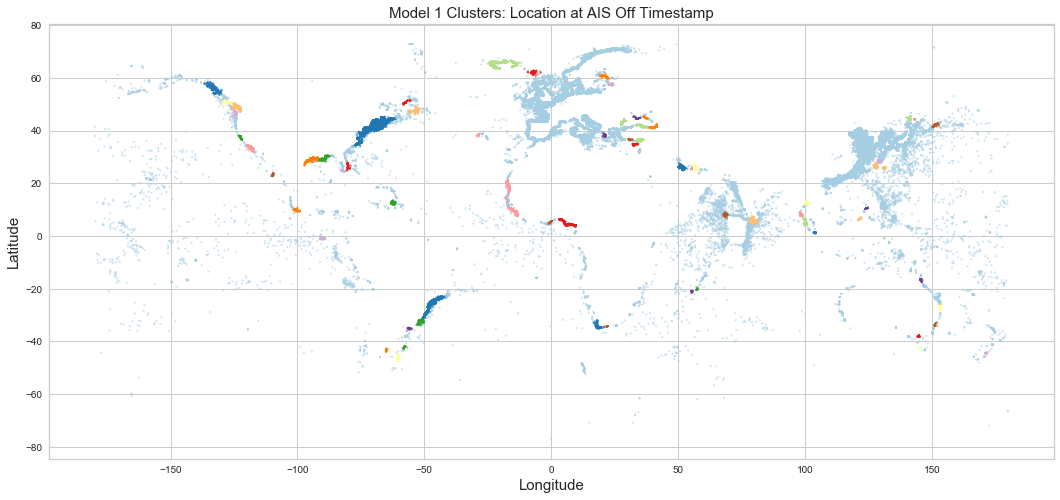

In [137]:
# Explore clusters visually
plt.figure(figsize=(18, 8))

plt.scatter(x=gap_notreg['off_lon'], 
            y=gap_notreg['off_lat'], 
            c=gap_notreg['mod1'], 
            s=3, 
            alpha=0.50,
            cmap='Paired')

plt.xlabel('Longitude', fontsize=15)
plt.ylabel('Latitude', fontsize=15)
plt.title('Model 1 Clusters: Location at AIS Off Timestamp', fontsize=15);

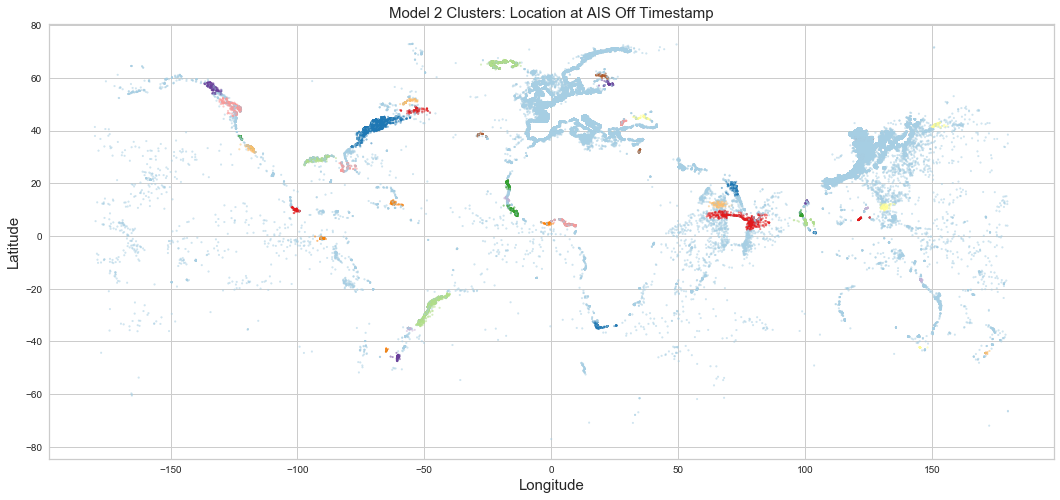

In [138]:
# Explore clusters visually
plt.figure(figsize=(18, 8))

plt.scatter(x=gap_notreg['off_lon'], 
            y=gap_notreg['off_lat'], 
            c=gap_notreg['mod2'], 
            s=3, 
            alpha=0.50,
            cmap='Paired')

plt.xlabel('Longitude', fontsize=15)
plt.ylabel('Latitude', fontsize=15)
plt.title('Model 2 Clusters: Location at AIS Off Timestamp', fontsize=15);

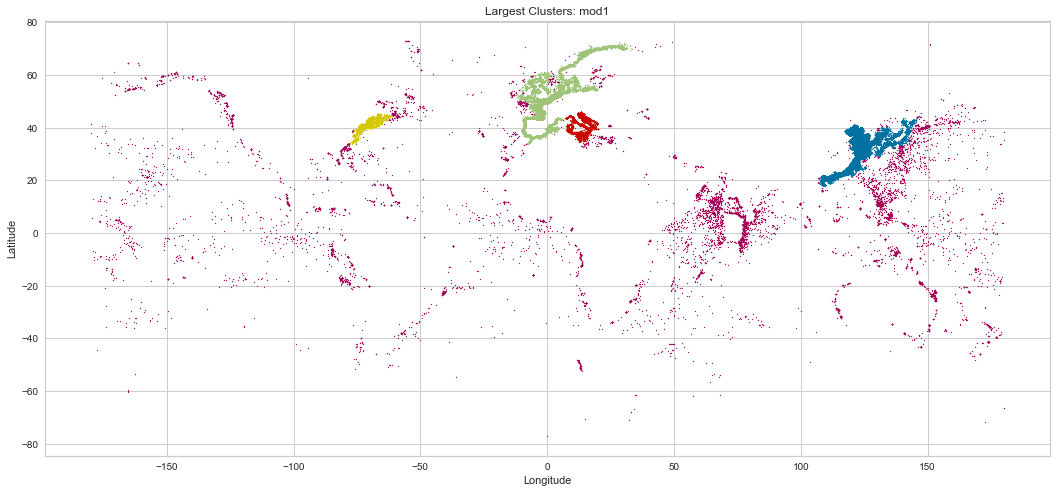

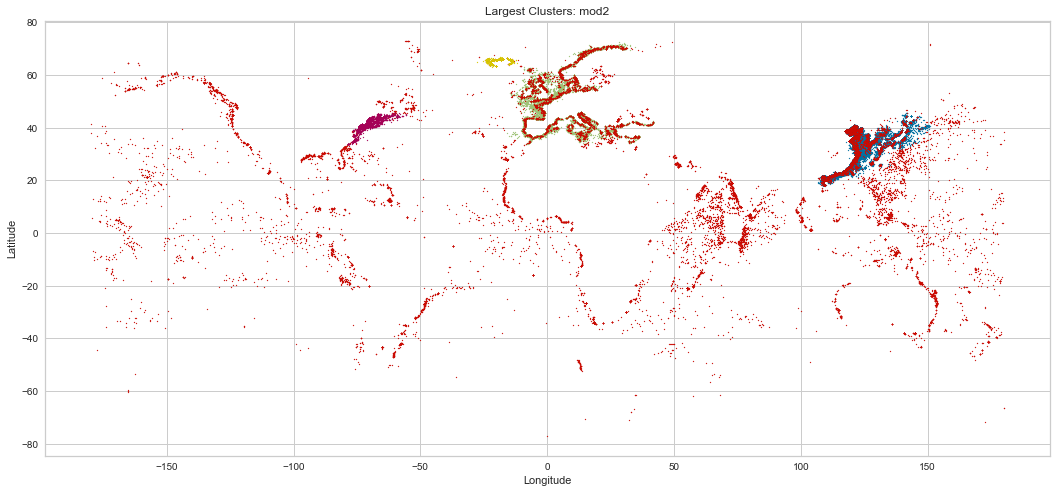

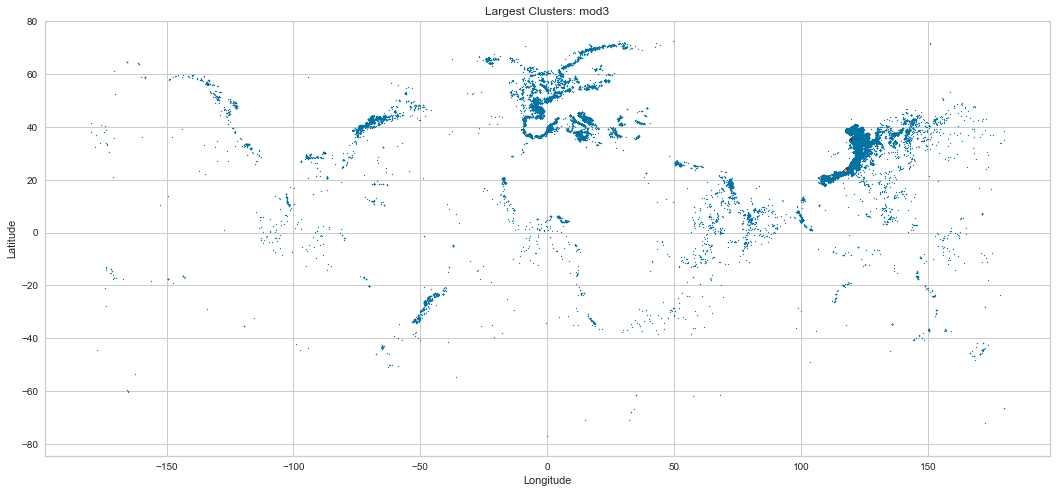

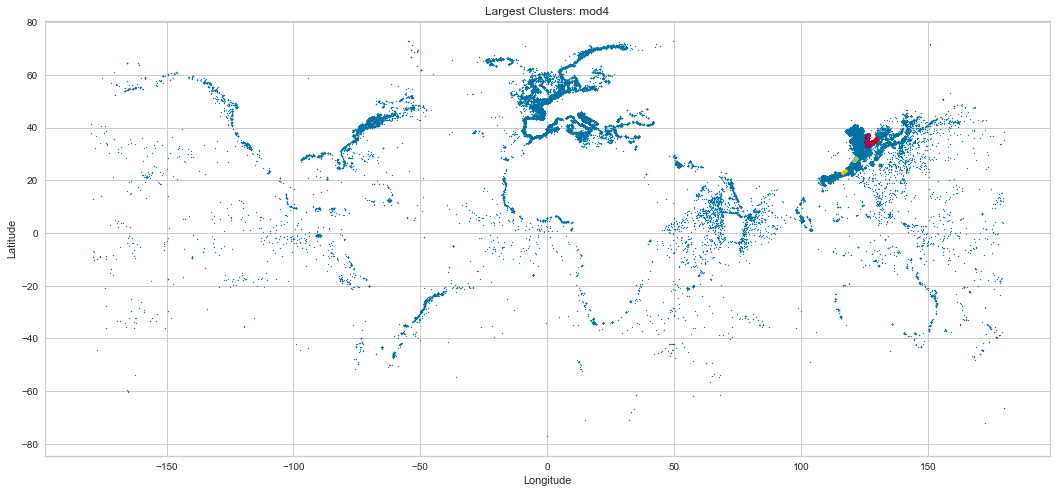

In [160]:
# Visualize largest 5 clusters estimated by each model

colors = ['darkred', 'skyblue', 'b', 'purple', 'darkorange']

def top_clusters(most, model):
    plt.figure(figsize=(18, 8))
    for label in most:
        cluster = gap_notreg[gap_notreg[model] == label]
        plt.scatter(cluster['off_lon'], cluster['off_lat'], s=1)
        plt.title(f"Largest Clusters: {model}")
        plt.xlabel('Longitude')
        plt.ylabel('Latitude');
        
top_clusters(mod1_most, 'mod1')   
top_clusters(mod2_most, 'mod2')
top_clusters(mod3_most, 'mod3')
top_clusters(mod4_most, 'mod4')

# EDA Clusters

In [44]:
# Explore any patterns in the first few clusters
gap_notreg.groupby('off_cluster')[['gap_hours', 
                                   'gap_distance_m',
                                   'positions_per_day', 
                                   'on_distance_from_shore_m',
                                   'off_distance_from_shore_m',]].mean().T.loc[:,[0,1,3]]

off_cluster,0,1,3
gap_hours,70.194658,37.730851,39.876446
gap_distance_m,26909.085504,9047.440903,24880.254694
positions_per_day,9.275423,8.543319,12.891640
on_distance_from_shore_m,12501.039076,6453.360118,24818.146793
off_distance_from_shore_m,12095.635080,6348.520744,25225.004816


In [45]:
# Check the distribution of gap hours in each cluster
def gaphr_hist(cluster):
    fig, ax = plt.subplots(figsize=(13,2))
    sns.boxplot(x=cluster['gap_hours'], ax=ax)
    ax.set_title(f"Gap Hour Distribution")
    ax.set_xlabel('Gap Hours')
    ax.tick_params(labelsize=10);
    

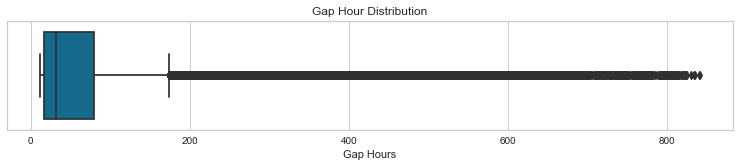

In [46]:
gaphr_hist(cluster0)

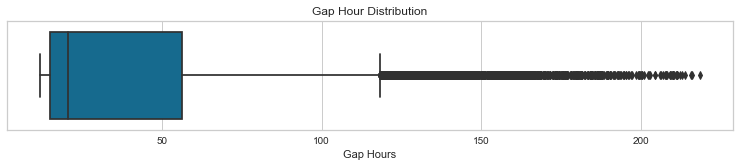

In [47]:
gaphr_hist(cluster1)

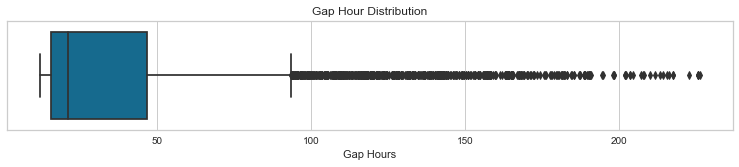

In [48]:
gaphr_hist(cluster3)

In [49]:
# Which clusters do worst vessels fall into (vessels appearing most fequently in dataset)
worst_mmsi_nums = [235067061, 412465495, 440152920, 416005071, 227594760]
worst_mmsi_df = gap_notreg[gap_notreg['mmsi'].isin(worst_mmsi_nums)]
worst_mmsi_df.groupby('mmsi')['off_cluster'].value_counts()

mmsi       off_cluster
227594760   1             46
           -1              1
235067061   1             54
412465495   0             49
416005071   0             47
440152920   0             48
Name: off_cluster, dtype: int64

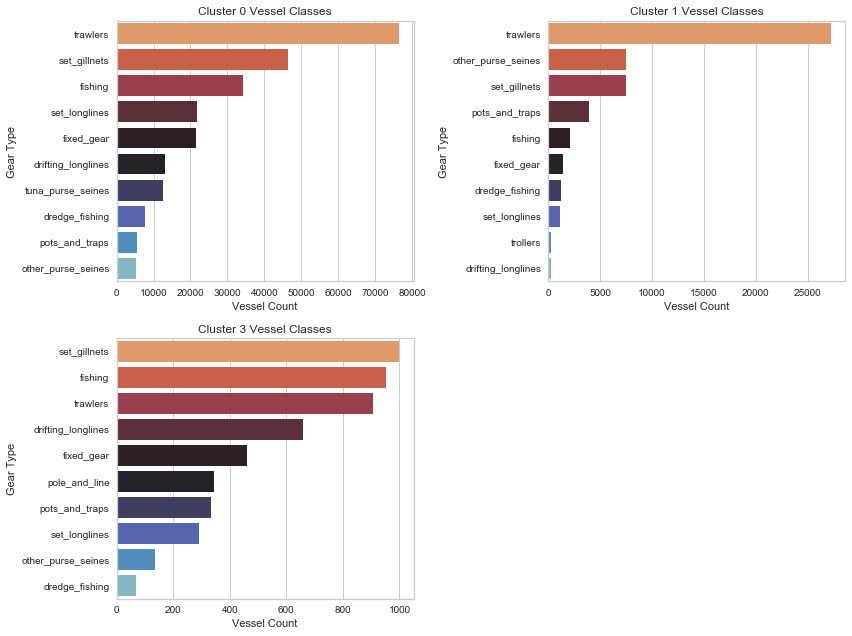

In [50]:
# Which vessel classes appear the most in each cluster and how often?

plt.figure(figsize=(12,9)) 

plt.subplot(2,2,1)
sns.countplot(y="vessel_class", 
              data=cluster0, 
              palette="icefire_r",
              order=cluster0['vessel_class'].value_counts().iloc[:10].index).set(title=('Cluster 0 Vessel Classes'),
                                                                                 xlabel=('Vessel Count'),
                                                                                 ylabel=('Gear Type'))
plt.subplot(2,2,2)
sns.countplot(y="vessel_class", 
              data=cluster1, 
              palette="icefire_r",
              order=cluster1['vessel_class'].value_counts().iloc[:10].index).set(title=('Cluster 1 Vessel Classes'),
                                                                                 xlabel=('Vessel Count'),
                                                                                 ylabel=('Gear Type'))
plt.subplot(2,2,3)
sns.countplot(y="vessel_class", 
              data=cluster3, 
              palette="icefire_r",
              order=cluster3['vessel_class'].value_counts().iloc[:10].index).set(title=('Cluster 3 Vessel Classes'),
                                                                                 xlabel=('Vessel Count'),
                                                                                 ylabel=('Gear Type'))
plt.tight_layout();

In [51]:
# What is the average length of gap event for the most common vessel class in each cluster?

print(f"Avg Length of Gap for Trawlers in Cluster 0: {cluster0.loc[cluster0['vessel_class'] == 'trawlers']['gap_hours'].mean().round(2)} hours")

print(f"Avg Length of Gap for Trawlers in Cluster 1: {cluster1.loc[cluster1['vessel_class'] == 'trawlers']['gap_hours'].mean().round(2)} hours")

print(f"Avg Length of Gap for Set Gillnets in Cluster 3: {cluster3.loc[cluster3['vessel_class'] == 'set_gillnets']['gap_hours'].mean().round(2)} hours")


Avg Length of Gap for Trawlers in Cluster 0: 67.46 hours
Avg Length of Gap for Trawlers in Cluster 1: 40.48 hours
Avg Length of Gap for Set Gillnets in Cluster 3: 40.66 hours


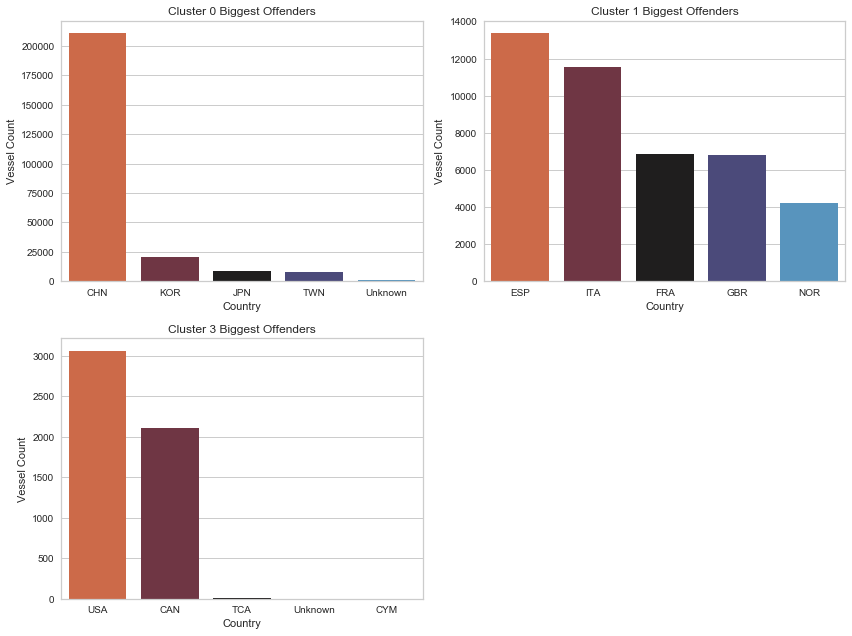

In [52]:
# Which countries are the biggest offenders in each cluster?

plt.figure(figsize=(12,9))

plt.subplot(2,2,1)
sns.countplot(x="flag", 
              data=cluster0, 
              palette="icefire_r",
              order=cluster0['flag'].value_counts().iloc[:5].index).set(title=('Cluster 0 Biggest Offenders'),
                                                                                 xlabel=('Country'),
                                                                                 ylabel=('Vessel Count'))
plt.subplot(2,2,2)
sns.countplot(x="flag", 
              data=cluster1, 
              palette="icefire_r",
              order=cluster1['flag'].value_counts().iloc[:5].index).set(title=('Cluster 1 Biggest Offenders'),
                                                                                 xlabel=('Country'),
                                                                                 ylabel=('Vessel Count'))
plt.subplot(2,2,3)
sns.countplot(x="flag", 
              data=cluster3, 
              palette="icefire_r",
              order=cluster3['flag'].value_counts().iloc[:5].index).set(title=('Cluster 3 Biggest Offenders'),
                                                                                 xlabel=('Country'),
                                                                                 ylabel=('Vessel Count'))
plt.tight_layout();

In [288]:
# Are there any relationships between location and the length of the gap event?
# Analyze gaps less than 1000 hrs (avg gap hours for each cluster between 30-70) 

def gaps_scatter(cluster, location):
    low_gaps = cluster[cluster['gap_hours'] < 1000]
    return low_gaps.plot(kind="scatter", 
                  x="off_lon",
                  y="off_lat", 
                  c="gap_hours",
                  cmap="icefire_r", 
                  figsize=(16, 8), 
                  s=4, 
                  title=f"Length of Gap Events in {location}")

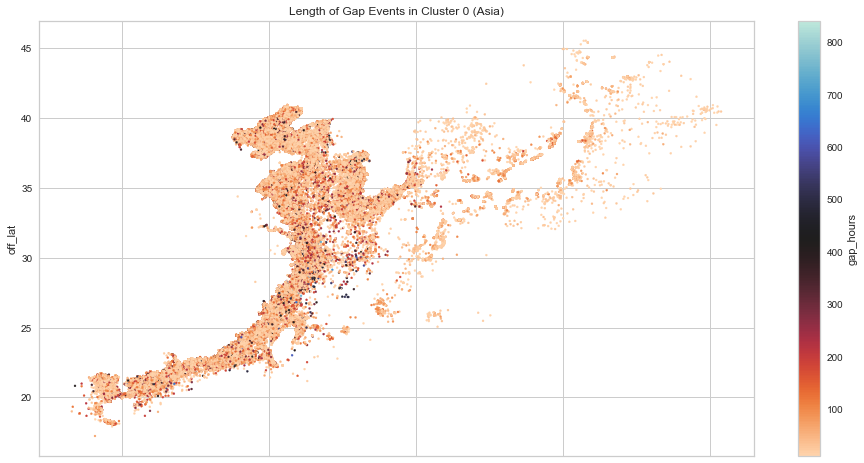

In [289]:
gaps_scatter(cluster0, 'Cluster 0 (Asia)');

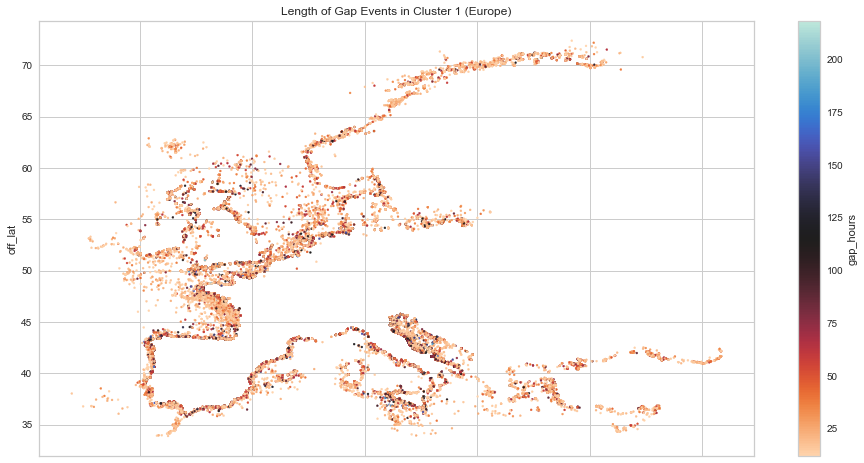

In [290]:
gaps_scatter(cluster1, 'Cluster 1 (Europe)');

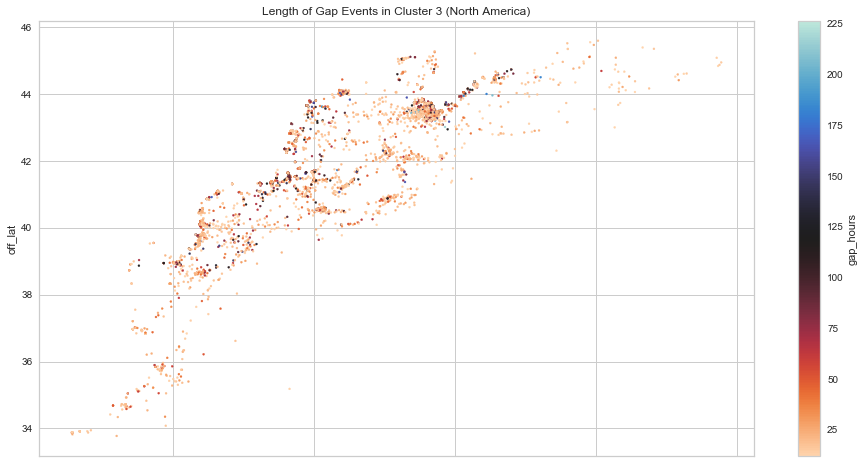

In [291]:
gaps_scatter(cluster3, 'Cluster 3 (North America)');

## Investigate Big Offenders

In [59]:
# Which vessels have the highest total gap hours?
top3 = gap_notreg.loc[(gap_notreg['off_cluster'] == 0) | (gap_notreg['off_cluster'] == 1)| (gap_notreg['off_cluster'] == 3)]
top3.groupby(['mmsi','vessel_class', 'off_cluster'])[['gap_hours']].sum().sort_values(by='gap_hours', ascending=False).head(10)


,,,gap_hours
mmsi,vessel_class,off_cluster,
333300571,fixed_gear,0,2915.016667
412268359,drifting_longlines,0,2850.316667
416211900,set_longlines,0,2810.316667
416001516,set_longlines,0,2809.050000
412413185,fixed_gear,0,2789.433333
412432591,fixed_gear,0,2694.983333
900406898,tuna_purse_seines,0,2694.866667
412417746,fishing,0,2666.350000
900019859,trawlers,0,2631.266667


In [60]:
cluster0.loc[cluster0['mmsi'] == 333300571]

,mmsi,gap_hours,gap_distance_m,gap_implied_speed_knots,positions_per_day,vessel_class,flag,off_timestamp,off_msgid,off_lat,...,off_receiver_type,off_distance_from_shore_m,on_timestamp,on_msgid,on_lat,on_lon,on_type,on_receiver_type,on_distance_from_shore_m,off_cluster
16966,333300571,274.950000,30438.273347,0.059776,0.742002,fixed_gear,CHN,2018-06-28 05:12:39+00:00,5e48b970-7f55-56ca-8f50-c144781d2077,26.640333,...,terrestrial,3000.0,2018-07-09 16:10:26+00:00,9533914c-3842-510f-96aa-06fed656ea90,26.368137,120.329170,B,terrestrial,12000.0,0
45205,333300571,141.350000,13617.881334,0.052020,0.020605,fixed_gear,CHN,2019-05-09 16:54:09+00:00,c5fc1aef-a808-5839-898d-42db12897bfe,26.337377,...,terrestrial,8000.0,2019-05-15 14:15:15+00:00,9a8af3fd-4bb3-5787-86f8-b1464f35c4ee,26.250535,120.306917,B,terrestrial,15000.0,0
61806,333300571,481.350000,9880.047457,0.011083,0.008214,fixed_gear,CHN,2019-01-29 03:25:39+00:00,5a6513a5-bad9-7dca-b48f-d0100f0c4f34,26.760158,...,terrestrial,8000.0,2019-02-18 04:47:18+00:00,c17bbd1b-6faa-38b0-1560-1a1a5d49f6ee,26.675125,120.208702,B,terrestrial,8000.0,0
69750,333300571,15.683333,10898.536027,0.375222,1.730198,fixed_gear,CHN,2019-09-28 12:13:55+00:00,e779836f-3140-508a-8f8a-f9c071cd7e68,26.761218,...,terrestrial,20000.0,2019-09-29 03:55:08+00:00,5701a60f-2636-53a5-a03a-3f886a07cfae,26.664553,120.537673,B,terrestrial,16000.0,0
125740,333300571,171.833333,6930.495944,0.021778,0.789002,fixed_gear,CHN,2018-10-27 02:31:21+00:00,19aba2db-1a3a-b76f-28c4-7fbb3ac1e92e,26.753568,...,terrestrial,6000.0,2018-11-03 06:22:00+00:00,86149c93-45aa-57f9-21ae-4b00c7a64ace,26.743007,120.223397,B,terrestrial,7000.0,0
128185,333300571,212.216667,5003.971013,0.012732,0.018515,fixed_gear,CHN,2019-04-30 17:32:31+00:00,d2030bfd-7ce2-55d5-8448-d4ec9d4bd506,26.667822,...,terrestrial,8000.0,2019-05-09 13:46:22+00:00,c2e4c242-d56b-07b8-e1fe-938d9c013475,26.710808,120.190637,B,terrestrial,5000.0,0
156657,333300571,99.500000,22228.725631,0.120629,0.742002,fixed_gear,CHN,2018-06-02 12:52:07+00:00,49e9662e-b2ca-0a8b-71dd-c4f602f3a97c,26.517322,...,terrestrial,14000.0,2018-06-06 16:22:11+00:00,14820906-5b35-7e7e-6d84-2bdb789af17d,26.712965,120.386267,B,terrestrial,3000.0,0
222769,333300571,130.033333,35116.126451,0.145818,0.174365,fixed_gear,CHN,2019-05-31 06:41:08+00:00,0ba01d27-4535-045f-61f9-e09ddbd08e14,25.714105,...,terrestrial,71000.0,2019-06-05 16:43:55+00:00,6a6e6067-f6cf-025b-d965-6ede8684be1f,25.421337,120.510318,B,terrestrial,64000.0,0
228471,333300571,112.816667,55943.840286,0.267755,0.020713,fixed_gear,CHN,2018-04-17 04:20:05+00:00,daa8df50-2f13-56b2-87dd-09084675360a,26.374960,...,terrestrial,5000.0,2018-04-21 21:09:31+00:00,5a0edfcb-2f6e-0f8d-e556-760648e4b049,26.264385,120.965470,B,terrestrial,48000.0,0
274356,333300571,83.633333,68062.820511,0.439430,3.965744,fixed_gear,CHN,2018-09-16 18:58:29+00:00,105125bb-6ef3-5c1e-8224-716b177bc181,26.643067,...,terrestrial,6000.0,2018-09-20 06:37:19+00:00,d0921760-77f6-b347-b0f8-f2be8635faa5,27.022703,120.752300,B,terrestrial,4000.0,0


# Conclusions

### Cluster 0 
- Largest cluster in dataset, comprising approximately 70% of the observations
- Average length of gap events in this cluster is 70 hours. 75% of the events last under 200 hrs (8 days) but there are many outliers including gap events as long as 800 hrs (1 month).  
- Trawling is the most widespread activity.
- Trawlers and set gillnets together comprise 50% of the activity seen in this cluster.
- The average length of a gap event for vessels using trawlers is lower than the cluster's average.

### Cluster 1 
-  Comprises approximately 15% of the observations in the dataset.
- The spread/distribution in length of gap events is much smaller than cluster 0 and the average length is around 38 hours. 
- This is interesting given trawling is also the most popular activity, but the average length of a gap event for vessels using trawlers is more aligned with the cluster's average.
- The average distance of a gap event is the smallest in this cluster, as well as the average number of positions each day.


### Cluster 3
- Third largest cluster in the dataset after noise (cluster -1). 
- The average length of gap events is 39 hrs, which is higher than in cluster 1, but shows a smaller spread given the smaller number of observations.
- The average gap distance is quite large and on par with the average in cluster 0.
- Set gillnets, fishing and trawlers are equally widespread activities in this area. They show average gap event lengths between 36-41 hours, consistent with the overall average.

# References
- https://stackoverflow.com/questions/27365467/can-pandas-plot-a-histogram-of-dates
- https://datascience.stackexchange.com/questions/46106/kmeans-vs-dbscan
- https://geoffboeing.com/2014/08/clustering-to-reduce-spatial-data-set-size/
- https://link.springer.com/chapter/10.1007/978-3-030-38081-6_2
- https://stackoverflow.com/questions/36220829/fine-control-over-the-font-size-in-seaborn-plots-for-academic-papers
- https://hdbscan.readthedocs.io/en/latest/parameter_selection.html
- https://hdbscan.readthedocs.io/en/latest/how_to_use_epsilon.html